In [1]:
# IMPORT PACKAGES

import numpy as np
import pandas as pd
#pd.set_option('display.max_rows', None)
import os
import glob
import re
import shutil
import warnings
import matplotlib.pyplot as plt
import math

In [10]:
#----------------------------------------------------------------------------------------------------------
# OPTIONS
#----------------------------------------------------------------------------------------------------------
dataset = "D7" # name of dataset which was used for the inversion
model = "newsmavg" # name of inversion
#----------------------------------------------------------------------------------------------------------

# identify events not relocated by gridlocj
not_relocated = True

# calculate and plot inversion model residuals
get_residuals = True

# identify high residual picks
identify_high_residual_P_picks = True
max_res_p = 0.1
identify_high_residual_S_picks = True
max_res_s = 0.25

In [11]:
# DEFINE FILE PATHS

path_to_nll_files = "/home/hra35/Documents/events/nll_script_outputs/"
path_to_dataset_files = os.path.join(path_to_nll_files, "%s" %dataset)

path_to_models = "/home/hra35/Documents/events/residuals"
path_to_model_files = os.path.join(path_to_models, model)

# files linking event IDs to FMTOMO IDs
p_association_file = os.path.join(path_to_dataset_files, "event_id_p.txt")
s_association_file = os.path.join(path_to_dataset_files, "event_id_s.txt")

# original traveltimes (otimesref.dat file)
p_otimes_path = os.path.join(path_to_model_files, "otimes_p.dat")
s_otimes_path = os.path.join(path_to_model_files, "otimes_s.dat")

# relocated traveltimes (otimes.dat file)
p_rtimes_path = os.path.join(path_to_model_files, "rtimes_p.dat")
s_rtimes_path = os.path.join(path_to_model_files, "rtimes_s.dat")

# full inversion model times (mtimes.dat file)
p_mtimes_path = os.path.join(path_to_model_files, "mtimes_p.dat")
s_mtimes_path = os.path.join(path_to_model_files, "mtimes_s.dat")

# initial 1D model traveltimes (arrivals.dat file)
p_mtimes_in_path = os.path.join(path_to_model_files, "mtimes_p_init.dat")
s_mtimes_in_path = os.path.join(path_to_model_files, "mtimes_s_init.dat")

# receiversref.in file for the model (to search for individual picks)
p_receiversref = os.path.join(path_to_model_files, "receiversref_p.in")
s_receiversref = os.path.join(path_to_model_files, "receiversref_s.in")

# receivers.in file for the model (to plot up the relocated events)
p_receivers = os.path.join(path_to_model_files, "receivers_p.in")
s_receivers = os.path.join(path_to_model_files, "receivers_s.in")

# sourceslocal_*.files (to search for individual picks)
p_sourceslocal = os.path.join(path_to_model_files, "sourceslocal_P.in")
s_sourceslocal = os.path.join(path_to_model_files, "sourceslocal_S.in")

# all picks dataframe
all_picks_df_path = os.path.join(path_to_dataset_files, "all_picks.txt")

# serror file for relocated events
#serror = os.path.join(path_to_model_files, "serror.dat")


In [12]:
# READ FILES INTO DATAFRAMES

# original traveltimes (otimesref.dat files)

if os.path.exists(p_otimes_path):
    otimes_p_df = pd.read_csv(p_otimes_path, sep=r'\s+', skiprows=1, names = ['event_no', 'station_no', 'rm1', 'rm2', 'tt', 'tt_error'])
    otimes_p_df.drop(['rm1', 'rm2'], axis=1, inplace=True)
    #print(len(otimes_p_df))
else:
    pass

if os.path.exists(s_otimes_path):
    otimes_s_df = pd.read_csv(s_otimes_path, sep=r'\s+', skiprows=1, names = ['event_no', 'station_no', 'rm1', 'rm2', 'tt', 'tt_error'])
    otimes_s_df.drop(['rm1', 'rm2'], axis=1, inplace=True)
    #print(len(otimes_s_df))
else:
    pass

# traveltimes for the relocated events (otimes.dat file)

if os.path.exists(p_rtimes_path):
    rtimes_p_df = pd.read_csv(p_rtimes_path, sep=r'\s+', skiprows=1, names = ['event_no', 'station_no', 'rm1', 'rm2', 'tt', 'rm3'])
    rtimes_p_df.drop(['rm1', 'rm2', 'rm3'], axis=1, inplace=True)
    #print(len(rtimes_p_df))
else:
    pass

if os.path.exists(s_rtimes_path):
    rtimes_s_df = pd.read_csv(s_rtimes_path, sep=r'\s+', skiprows=1, names = ['event_no', 'station_no', 'rm1', 'rm2', 'tt', 'rm3'])
    rtimes_s_df.drop(['rm1', 'rm2', 'rm3'], axis=1, inplace=True)
    #print(len(rtimes_s_df))
else:
    pass

# inversion model times (mtimes.dat file)

if os.path.exists(p_mtimes_path):
    mtimes_p_df = pd.read_csv(p_mtimes_path, sep=r'\s+', skiprows=0, names = ['event_no', 'station_no', 'rm1', 'rm2', 'tt_m', 'rm3', 'rm4'])
    mtimes_p_df.drop(['rm1', 'rm2', 'rm3', 'rm4'], axis=1, inplace=True)
    #print(len(mtimes_p_df))
else:
    pass

if os.path.exists(s_mtimes_path):
    mtimes_s_df = pd.read_csv(s_mtimes_path, sep=r'\s+', skiprows=0, names = ['event_no', 'station_no', 'rm1', 'rm2', 'tt_m', 'rm3', 'rm4'])
    mtimes_s_df.drop(['rm1', 'rm2', 'rm3', 'rm4'], axis=1, inplace=True)
    #print(len(mtimes_s_df))
else:
    pass
      
# initial model times (arrivals.dat file)

if os.path.exists(p_mtimes_in_path):
    mtimes_p_in_df = pd.read_csv(p_mtimes_in_path, sep=r'\s+', skiprows=0, names = ['event_no', 'station_no', 'rm1', 'rm2', 'tt_m', 'rm3', 'rm4'])
    mtimes_p_in_df.drop(['rm1', 'rm2', 'rm3', 'rm4'], axis=1, inplace=True)
    #print(len(mtimes_p_in_df))
else:
    pass

if os.path.exists(s_mtimes_in_path):
    mtimes_s_in_df = pd.read_csv(s_mtimes_in_path, sep=r'\s+', skiprows=0, names = ['event_no', 'station_no', 'rm1', 'rm2', 'tt_m', 'rm3', 'rm4'])
    mtimes_s_in_df.drop(['rm1', 'rm2', 'rm3', 'rm4'], axis=1, inplace=True)
    #print(len(mtimes_s_in_df))
else:
    pass


# pick dataframe
all_picks_df = pd.read_csv(all_picks_df_path, sep=r'\s+', header=0)



In [13]:
if not_relocated == True:
    
    # calculate origin time change and identify events for which it is 0
    p_otime_df = pd.DataFrame({'Time_change': (rtimes_p_df["tt"] - otimes_p_df["tt"])})
    
    # create a combined dataframe for P-wave data
    P_df_reloc = pd.concat([otimes_p_df['event_no'], otimes_p_df['station_no'], p_otime_df], axis=1)

    P_df_reloc.loc[:, 'station_ID'] = " "
    P_df_reloc.loc[:, 'event_ID'] = " "

    # read the sourceslocal_P file to get station IDs
    with open(p_sourceslocal, 'r') as file:
        station_lines = file.readlines()

    # save station IDs to dataframe
    for station in P_df_reloc['station_no']:
    
        station_line = station_lines[station*3]
        entries = station_line.split()
        station_file = entries[2]
        station_id = station_file.split('.')[0]
    
        P_df_reloc.loc[P_df_reloc['station_no'] == station, 'station_ID'] = station_id

    # read in the event ID association file and add to dataframes
    event_id_p = pd.read_csv(p_association_file, delimiter='\t')
    P_df_reloc["event_ID"] = event_id_p["event_ID"]

    # identify picks that haven't been relocated
    mask = P_df_reloc['Time_change'] == 0
    not_relocated_p = P_df_reloc[mask]

    # output as file
    not_relocated_p.to_csv(os.path.join(path_to_model_files, "not_relocated_p.txt"), sep='\t', index=False)

    #print(len(not_relocated_p))
    #print(not_relocated_p)
    
#-------------------------------------------------------------------------------------------------------------------------------
    
    # calculate origin time change and identify events for which it is 0
    s_otime_df = pd.DataFrame({'Time_change': (rtimes_s_df["tt"] - otimes_s_df["tt"])})
    
    # create a combined dataframe for S-wave data
    S_df_reloc = pd.concat([otimes_s_df['event_no'], otimes_s_df['station_no'], s_otime_df], axis=1)

    S_df_reloc.loc[:, 'station_ID'] = " "
    S_df_reloc.loc[:, 'event_ID'] = " "

    # read the sourceslocal_P file to get station IDs
    with open(s_sourceslocal, 'r') as file:
        station_lines = file.readlines()

    # save station IDs to dataframe
    for station in S_df_reloc['station_no']:
    
        station_line = station_lines[station*3]
        entries = station_line.split()
        station_file = entries[2]
        station_id = station_file.split('.')[0]
    
        S_df_reloc.loc[S_df_reloc['station_no'] == station, 'station_ID'] = station_id

    # read in the event ID association file and add to dataframes
    event_id_s = pd.read_csv(s_association_file, delimiter='\t')
    S_df_reloc["event_ID"] = event_id_s["event_ID"]

    # identify picks with high residuals
    mask = S_df_reloc['Time_change'].abs() == 0
    not_relocated_s = S_df_reloc[mask]

    # output picks to remove as a file
    not_relocated_s.to_csv(os.path.join(path_to_model_files, "not_relocated_s.txt"), sep='\t', index=False)

    #print(len(not_relocated_s))
    #print(not_relocated_s) 
   

In [14]:
if get_residuals == True:
    
    # calculate full inversion residuals (and save into files for GMT)
    p_residual_df = pd.DataFrame({'Residual': (mtimes_p_df['tt_m'])-(rtimes_p_df['tt'])})
    p_residual_df.to_csv(os.path.join(path_to_model_files, "p_residuals.txt"), index=False, header=False, sep="\t")
    s_residual_df = pd.DataFrame({'Residual': (mtimes_s_df['tt_m'])-(rtimes_s_df['tt'])})
    s_residual_df.to_csv(os.path.join(path_to_model_files, "s_residuals.txt"), index=False, header=False, sep="\t")
                     
    # calculate initial model residuals (and save into files for GMT)
    p_residual_in_df = pd.DataFrame({'Residual': mtimes_p_in_df['tt_m']-otimes_p_df['tt']})
    p_residual_in_df.to_csv(os.path.join(path_to_model_files, "p_initial_residuals.txt"), index=False, header=False, sep="\t")                     
    s_residual_in_df = pd.DataFrame({'Residual': mtimes_s_in_df['tt_m']-otimes_s_df['tt']})
    s_residual_in_df.to_csv(os.path.join(path_to_model_files, "s_initial_residuals.txt"), index=False, header=False, sep="\t")
                        
    # calculate rms of the residuals to check against residuals.dat as a sanity check
    def calc_rms(residuals):
        residuals = np.array(residuals, dtype=np.float64)
        squared_errors = np.square(residuals)
        rms = np.sqrt(np.sum(squared_errors) / len(residuals))
        return rms

    residuals = p_residual_in_df["Residual"]
    rms = 1000 * calc_rms(residuals)
    print("Initial Vp model rms: ", rms)
    
    residuals = p_residual_df["Residual"]
    rms = 1000 * calc_rms(residuals)
    print("Final Vp model rms: ", rms)
    
    residuals = s_residual_in_df["Residual"]
    rms = 1000 * calc_rms(residuals)
    print("Initial Vs model rms: ", rms)
    
    residuals = s_residual_df["Residual"]
    rms = 1000 * calc_rms(residuals)
    print("Final Vs model rms: ", rms)
    
    # total residual RMS (P+S)
    all_resids = []
    for i in range(len(p_residual_in_df)):
        all_resids.append(p_residual_in_df["Residual"].values[i])
    for i in range(len(s_residual_in_df)):
        all_resids.append(s_residual_in_df["Residual"].values[i])
    
    rms = 1000 * calc_rms(all_resids)
    print("RMS residual, Vp and Vs combined: ", rms)


Initial Vp model rms:  106.417358131617
Final Vp model rms:  42.54599896891368
Initial Vs model rms:  188.35824943509203
Final Vs model rms:  64.15611847404088
RMS residual, Vp and Vs combined:  151.80702193931376


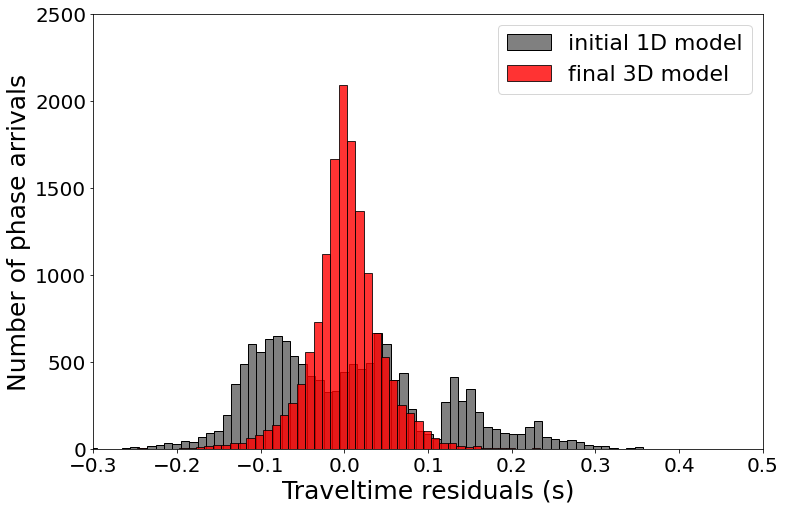

In [17]:
# PLOT P-VELOCITY HISTOGRAMS

if get_residuals == True:
    
    plt.figure(figsize=(12,8))

    bin_width = 0.01

    data_min_1 = np.min(p_residual_in_df['Residual'])
    data_max_1 = np.max(p_residual_in_df['Residual'])
    num_bins_1 = int((data_max_1 - data_min_1) / bin_width)

    data_min_2 = np.min(p_residual_df['Residual'])
    data_max_2 = np.max(p_residual_df['Residual'])
    num_bins_2 = int((data_max_2 - data_min_2) / bin_width)

    plt.hist(p_residual_in_df['Residual'], bins=num_bins_1, color='grey', edgecolor='k', alpha=1, label='initial 1D model')
    plt.hist(p_residual_df['Residual'], bins=num_bins_2, color='red', edgecolor='k', alpha=0.8, label='final 3D model')

    #plt.title('P-wave traveltime residuals', fontsize=25)
    plt.xlabel('Traveltime residuals (s)',  fontsize=25)
    plt.ylabel('Number of phase arrivals', fontsize=25)
    plt.xlim(-0.3, 0.5)
    plt.ylim(0, 2500)
    plt.legend(fontsize=22)
    plt.xticks(fontsize=20)
    plt.yticks(fontsize=20)

    plt.savefig(os.path.join(path_to_model_files, 'p_residuals.png'))
    #plt.show()

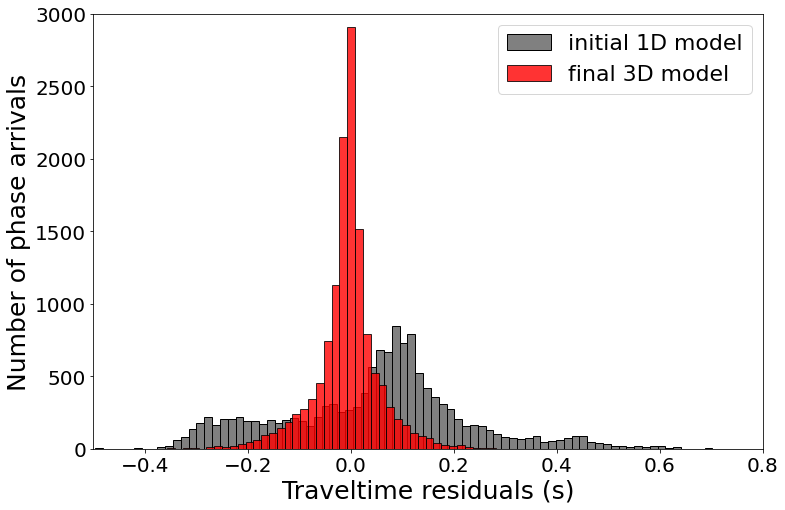

In [18]:
# PLOT S-VELOCITY HISTOGRAMS
    
if get_residuals == True:
    
    plt.figure(figsize=(12,8))

    bin_width = 0.015

    data_min_1 = np.min(s_residual_in_df['Residual'])
    data_max_1 = np.max(s_residual_in_df['Residual'])
    num_bins_1 = int((data_max_1 - data_min_1) / bin_width)

    data_min_2 = np.min(s_residual_df['Residual'])
    data_max_2 = np.max(s_residual_df['Residual'])
    num_bins_2 = int((data_max_2 - data_min_2) / bin_width)

    plt.hist(s_residual_in_df['Residual'], bins=num_bins_1, color='grey', edgecolor='k', alpha=1, label='initial 1D model')
    plt.hist(s_residual_df['Residual'], bins=num_bins_2, color='red', edgecolor='k', alpha=0.8, label='final 3D model')

    #plt.title('S-wave traveltime residuals')
    plt.xlabel('Traveltime residuals (s)', fontsize=25)
    plt.ylabel('Number of phase arrivals', fontsize=25)
    plt.ylim(0, 3000)
    plt.xlim(-0.5,0.8)
    plt.legend(fontsize=22)
    plt.xticks(fontsize=20)
    plt.yticks(fontsize=20)
    
    plt.savefig(os.path.join(path_to_model_files, 's_residuals.png'))
    #plt.show()

In [9]:
if identify_high_residual_P_picks == True:

    # create a combined dataframe for P-wave data
    P_df = pd.concat([otimes_p_df['event_no'], otimes_p_df['station_no'], otimes_p_df['tt'], p_residual_df], axis=1)

    P_df.loc[:, 'station_ID'] = " "
    P_df.loc[:, 'event_ID'] = " "

    # read the sourceslocal_P file to get station IDs
    with open(p_sourceslocal, 'r') as file:
        station_lines = file.readlines()

    # save station IDs to dataframe
    for station in P_df['station_no']:
    
        station_line = station_lines[station*3]
        entries = station_line.split()
        station_file = entries[2]
        station_id = station_file.split('.')[0]
    
        P_df.loc[P_df['station_no'] == station, 'station_ID'] = station_id

    # read in the event ID association file and add to dataframes
    event_id_p = pd.read_csv(p_association_file, delimiter='\t')
    P_df["event_ID"] = event_id_p["event_ID"]

    # identify picks with high residuals
    mask = P_df['Residual'].abs() > max_res_p
    picks_to_rm_p = P_df[mask]

    # output picks to remove as a file
    picks_to_rm_p.to_csv(os.path.join(path_to_model_files, "p_picks_rm.txt"), sep='\t', index=False)

    #print(len(picks_to_rm_p))
    #print(picks_to_rm_p)

In [10]:
if identify_high_residual_S_picks == True:

    # create a combined dataframe for P-wave data
    S_df = pd.concat([otimes_s_df['event_no'], otimes_s_df['station_no'], otimes_s_df['tt'], s_residual_df], axis=1)

    S_df.loc[:, 'station_ID'] = " "
    S_df.loc[:, 'event_ID'] = " "

    # read the sourceslocal_S file to get station IDs
    with open(s_sourceslocal, 'r') as file:
        station_lines = file.readlines()

    # save station IDs to dataframe
    for station in S_df['station_no']:
    
        station_line = station_lines[station*3]
        entries = station_line.split()
        station_file = entries[2]
        station_id = station_file.split('.')[0]
    
        S_df.loc[S_df['station_no'] == station, 'station_ID'] = station_id

    # read in the event ID association file and add to dataframe
    event_id_s = pd.read_csv(s_association_file, delimiter='\t')
    S_df["event_ID"] = event_id_s["event_ID"]

    # identify picks with high residuals
    mask = S_df['Residual'].abs() > max_res_s
    picks_to_rm_s = S_df[mask]

    # output picks to remove as a file
    picks_to_rm_s.to_csv(os.path.join(path_to_model_files, "s_picks_rm.txt"), sep='\t', index=False)

    #print(len(picks_to_rm_s))
    #print(picks_to_rm_s)

In [11]:
if not_relocated == True:
    
    not_relocated_df = pd.concat([not_relocated_s, not_relocated_p], ignore_index=True)
    grouped_reloc_df = not_relocated_df.groupby("event_ID")
    print(len(grouped_reloc_df))
    
    not_relocated_events = []
    for group_name, group_data in grouped_reloc_df:
        not_relocated_events.append(group_name)
        
    all_picks_grouped = all_picks_df.groupby("event_ID")
    
    for group_name, group_data in all_picks_grouped:
        if group_name in not_relocated_events:
            print(group_name)
            #print(group_data)

0
